# Factors Influencing Stroke

A predictive model is trained on a healthcare dataset containing features such as gender, the presence of heart disease and
occupation in order to predict the likelihood of an individual having a stroke. 

In [1]:
# Import necessary packages 
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.svm import LinearSVC, SVC
from sklearn.utils import resample
from sklearn.manifold import TSNE
import eli5
from sklearn.neighbors import KNeighborsClassifier
from matplotlib import pyplot as plt

C:\Users\josep\anaconda3\envs\sensyne\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
C:\Users\josep\anaconda3\envs\sensyne\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


## Exploratory Data Analysis

In [2]:
# Import the training dataset from the .csv file and drop the "id" column
raw_df = pd.read_csv("data/train_2v.csv")
raw_df.drop(["id"], axis=1, inplace=True)

In [3]:
# Describe the numerical data in the dataset
raw_df.describe()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,43400.000000,43400.000000,43400.000000,43400.000000,41938.000000,43400.000000
mean,42.217894,0.093571,0.047512,104.482750,28.605038,0.018041
std,22.519649,0.291235,0.212733,43.111751,7.770020,0.133103
min,0.080000,0.000000,0.000000,55.000000,10.100000,0.000000
25%,24.000000,0.000000,0.000000,77.540000,23.200000,0.000000
50%,44.000000,0.000000,0.000000,91.580000,27.700000,0.000000
75%,60.000000,0.000000,0.000000,112.070000,32.900000,0.000000
max,82.000000,1.000000,1.000000,291.050000,97.600000,1.000000


In [4]:
# Describe the non-numerical data in the dataset
raw_df.describe(exclude='number')

,gender,ever_married,work_type,Residence_type,smoking_status
count,43400,43400,43400,43400,30108
unique,3,2,5,2,3
top,Female,Yes,Private,Urban,never smoked
freq,25665,27938,24834,21756,16053


In [5]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43400 entries, 0 to 43399
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             43400 non-null  object 
 1   age                43400 non-null  float64
 2   hypertension       43400 non-null  int64  
 3   heart_disease      43400 non-null  int64  
 4   ever_married       43400 non-null  object 
 5   work_type          43400 non-null  object 
 6   Residence_type     43400 non-null  object 
 7   avg_glucose_level  43400 non-null  float64
 8   bmi                41938 non-null  float64
 9   smoking_status     30108 non-null  object 
 10  stroke             43400 non-null  int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 3.6+ MB


The raw dataset contains 43400 entries including numerical and non-numerical data types. Some of the features contain continuous data, for example: avg_glucose_level and age; while some of the features contain categorical data such as gender and work_type. The categorical data is sometimes inherently binary, such as the presence of hypertension or heart_disease, whereas some are fall into a broader range of categories such as smoking_status.

## Pre-Processing

### Gender

Investigation of the data showed that there were three gender classifications: male, female and other. Whilst perhaps
insensitive, data points containing the other classification were dropped for three reasons:

1. There are only 11 data points
2. Each of those datapoints has never had a stroke, so the model may fit to other being a significant factor in predicting
stroke (or lack thereof)
3. Other is ambiguous from a statistical analysis viewpoint and could fit a number of descriptions that we cannot discern
from the data.

In [6]:
# Create a new DataFrame where gender = 'Other' is not included
df_gender = raw_df[raw_df['gender'] != 'Other']

### Looking at blanks in the data

In [7]:
# Fill any blank elements in the DataFrame with np.NaN and count the number of NaN per feature
df_gender.fillna(np.nan)
df_gender.isna().sum()

gender                   0
age                      0
hypertension             0
heart_disease            0
ever_married             0
work_type                0
Residence_type           0
avg_glucose_level        0
bmi                   1458
smoking_status       13290
stroke                   0
dtype: int64

In [8]:
# Calculate what proportion of each column is NaN
df_gender.isna().sum() / len(df_gender)

gender               0.000000
age                  0.000000
hypertension         0.000000
heart_disease        0.000000
ever_married         0.000000
work_type            0.000000
Residence_type       0.000000
avg_glucose_level    0.000000
bmi                  0.033603
smoking_status       0.306299
stroke               0.000000
dtype: float64

30.6% of smoking_status entries are unfilled, which is a much larger percentage than bmi. However, intuition here suggests that smoking could be a significant contributor. As stated before, this dataset is already quite large, so dropping 30% of the data points still leaves a large dataset. With this in mind, the decision was taken to drop the unfilled data points. 

In [9]:
# Create a new DataFrame will full smoking data by dropping NaN entries from the previous DataFrame
df_smoking = df_gender.dropna()

A ‘healthy’ BMI isn’t necessarily as higher BMI. Rather, one’s divergence from a healthy BMI can go one of two ways: lower (underweight) or higher (overweight). Which way you go is likely to affect the kind of health conditions you develop. For example, a person who is obese is more likely to develop Type 2 diabetes than a person who is underweight, who might be more likely to suffer from malnutrition. Because of this, it makes sense to split up the BMI feature into underweight and overweight, so that the model can assess which of the two is more linked to stroke.

To do this, a ‘healthy’ BMI of 25 was chosen and for each data point the difference between the actual BMI and the healthy BMI
was calculated and labelled ‘underweight’ and ‘overweight’ accordingly. An example is seen below:

BMI | overweight | underweight
---|---|---
35.9 | 10.9 | 0.0
25.0 | 0.0 | 0.0
23.0 | 0.0 | 2.0


In [10]:
# A healthy value for BMI doesn't scale from 0, so we set a healthy value 
healthy_bmi = 25

In [11]:
# Then we scale off this healthy value, where anything over it is 'overweight' and anything under is 'underweight'
for i in df_smoking.index:
    if df_smoking.at[i, "bmi"] - healthy_bmi > 0:
        df_smoking.at[i, 'overweight'] = df_smoking.at[i, "bmi"] - healthy_bmi
        df_smoking.at[i, 'underweight'] = 0
    elif df_smoking.at[i, "bmi"] - healthy_bmi < 0:
        df_smoking.at[i, 'underweight'] = abs(df_smoking.at[i, "bmi"] - healthy_bmi)
        df_smoking.at[i, 'overweight'] = 0
    else:
        df_smoking.at[i, 'underweight'] = 0
        df_smoking.at[i, 'overweight'] = 0

C:\Users\josep\anaconda3\envs\sensyne\lib\site-packages\pandas\core\indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\josep\anaconda3\envs\sensyne\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [12]:
# Then, we can drop the original BMI column from the dataset and create a new one
df_bmi = df_smoking.drop('bmi', axis=1)

Another thing to deal with is how we now have three categorical values for smoking_status: smokes, formerly smoked and never smoked. This strikes me as an *ordinal* data type, i.e. smoking should have more weighting than formerly smoked which should have more weighting than never smoked. So, I'll use an OrdinalEncoder to do this. 

In [13]:
# Instantiate an ordinal encoder with the categories ranked in order of the inherent hierarchy of smoking data 
smoking_encoder = OrdinalEncoder(categories=[('never smoked', 'formerly smoked', 'smokes')])

#  Fit the encoder to the DataFrame and transform the categorical data into a ordinal encoded data 
df_bmi[['smoking_status']] = smoking_encoder.fit_transform(df_bmi[['smoking_status']])

For the residence types, there is no obvious hierarchy to the data. So we will use a OneHotEncoder to convert one column of 2 unique data into 2 columns of binary data. 

In [14]:
# Generate binary values using get_dummies
dum_df = pd.get_dummies(df_bmi, columns=["Residence_type"], prefix=["Residence_is"] )

# We can then drop one of these columns since these are mutally exclusive features, i.e. presence of a 1 in the first column
# implies a 0 in the second column and vice-versa
dum_df.drop('Residence_is_Urban', axis=1, inplace=True)

Use feature selection to realise 'ever married' isn't related data to our analysis here. 

In [15]:
# Drop 'ever_married' feauture
dum_df.drop('ever_married', axis=1, inplace=True)

For our modified DataSet, 'gender' is binary data so we can use an OrdinalEncoder to automaticallyt change Male into 1 and Female into 0

In [16]:
# Instantiate an OrdinalEncoder for encoding the gender feature
gender_encoder = OrdinalEncoder()

#  Fit the encoder to the DataFrame and transform 
dum_df[['gender']] = gender_encoder.fit_transform(dum_df[['gender']])

In [17]:
# Rename the gender column to 'is_male' to make it clear that 1 is male and 0 is female
dum_df.rename(columns={'gender': 'is_male'}, inplace=True)

In [18]:
# Same logic applied to 'work_type' as does to 'residence_type' so use a OneHotEncoder 
work_df = pd.get_dummies(dum_df, columns=["work_type"])

In [19]:
# Rearrange columns so that features are on the LHS and the stroke label is the last column
cols = work_df.columns.to_list()
cols.pop(6)
cols.append('stroke')
df = work_df[cols]

In [20]:
# Finally let's use the .head() method on our final Dataframe to see if it's looking as we expect
df.head()

,is_male,age,hypertension,heart_disease,avg_glucose_level,smoking_status,overweight,underweight,Residence_is_Rural,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,stroke
1,1.0,58.0,1,0,87.96,0.0,14.2,0.0,0,0,0,1,0,0,0
3,0.0,70.0,0,0,69.04,1.0,10.9,0.0,1,0,0,1,0,0,0
6,0.0,52.0,0,0,77.59,1.0,0.0,7.3,0,0,0,1,0,0,0
7,0.0,75.0,0,1,243.53,0.0,2.0,0.0,1,0,0,0,1,0,0
8,0.0,32.0,0,0,77.67,2.0,7.3,0.0,1,0,0,1,0,0,0


## Dealing with imbalance

From inspection we seem to have an imbalanced data set, let's investigate to see how bad it really is:

In [21]:
# Separate stroke and no_stroke classes
df_no_stroke = df[df.stroke==0]
df_stroke = df[df.stroke==1]

In [22]:
# Count the number of nno stroke datapoints
df_no_stroke.count()

is_male                    28517
age                        28517
hypertension               28517
heart_disease              28517
avg_glucose_level          28517
smoking_status             28517
overweight                 28517
underweight                28517
Residence_is_Rural         28517
work_type_Govt_job         28517
work_type_Never_worked     28517
work_type_Private          28517
work_type_Self-employed    28517
work_type_children         28517
stroke                     28517
dtype: int64

In [23]:
# Count the number of stroke data points
df_stroke.count()

is_male                    548
age                        548
hypertension               548
heart_disease              548
avg_glucose_level          548
smoking_status             548
overweight                 548
underweight                548
Residence_is_Rural         548
work_type_Govt_job         548
work_type_Never_worked     548
work_type_Private          548
work_type_Self-employed    548
work_type_children         548
stroke                     548
dtype: int64

Obviously this is massive imbalance: strokes account for 1.92% of the data! We will need to undergo some kind of balancing measure, otherwise when we train our model it will overfit to no stroke data points. 

We have two options: upsampling the stroke entries to the same count as the no stroke entries and downsampling the
no stroke entries to the same count as the stroke entries. In either case, the imbalance will still prove to be a problem. Up
sampling the data will cause the model to overfit to the training set and down sampling means throwing away about 92% of the
data. However, for the purposes of generalisation, it is likely that downsampling would be the better of the two options. We'll look at both either way...

## Upsampling 

We'll start by upsampling the stroke data entries to the size of the no stroke entries. Bare in mind that this is a **massive** upsample, and may result in us overfitting to our training data.

In [24]:
# Upsample stroke class
df_stroke_upsampled = resample(df_stroke, 
                               replace=True,       
                               n_samples=28517,   
                               random_state=123)   

In [25]:
# Combine no stroke class with upsampled stroke class
df_upsampled = pd.concat([df_no_stroke, df_stroke_upsampled])

In [26]:
# Check to make sure the dimensions are now the same 
df_upsampled.stroke.value_counts()

1    28517
0    28517
Name: stroke, dtype: int64

### Training the SVC model

We'll fit the model using the SVC class from scikit-learn. A train/test split of 70/30 will be used to generate a labelled test batch for model evaluation. Then we'll rescale the data between 0 and 1 to ensure an equal importance of each feature.
Since the dataset had non-linear relationships between some of the features, SVC is chosen over linear SVC in order to
improve the fit.

In [27]:
# Split the upsampled DataFrame into features and labels 
X_up, y_up = df_upsampled.iloc[:, :14], df_upsampled.iloc[:, 14:]

In [28]:
# Use train_test_split from scikit-learn to split the training data into a training set and a testing set
X_up_train, X_up_test, y_up_train, y_up_test = train_test_split(X_up,
                                                                y_up,
                                                                test_size=0.3)

In [29]:
# Scale the feature data between 0-1 
scaler = MinMaxScaler(feature_range=(0, 1))
rescaledX_up_train = scaler.fit_transform(X_up_train)
rescaledX_up_test = scaler.fit_transform(X_up_test)
print(rescaledX_up_train)

[[0.         0.77777778 0.         ... 0.         1.         0.        ]
 [0.         0.30555556 0.         ... 1.         0.         0.        ]
 [1.         0.18055556 0.         ... 1.         0.         0.        ]
 ...
 [1.         0.06944444 0.         ... 0.         1.         0.        ]
 [0.         0.23611111 0.         ... 1.         0.         0.        ]
 [0.         0.98611111 0.         ... 0.         1.         0.        ]]


In [30]:
# Instantiate a LinearSVC (so we can use ELI5) and an SVC object
model_up_linear = LinearSVC()
model_up = SVC()

# Fit the model the the upscaled training data
model_up.fit(rescaledX_up_train, y_up_train)
model_up_linear.fit(rescaledX_up_train, y_up_train)

C:\Users\josep\anaconda3\envs\sensyne\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\josep\anaconda3\envs\sensyne\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

In [31]:
# Predict the results of the upscaled testing data and print the accuracy score against the actual label
prediction_up = model_up.predict(rescaledX_up_test)
prediction_up_linear = model_up_linear.predict(rescaledX_up_test)
print(accuracy_score(y_up_test, prediction_up))
print(accuracy_score(y_up_test, prediction_up_linear))

0.8020571562153
0.766466016013091


### Interpreting the model

I will use eli5 to diplay feature weights in the model so that we can practically interpret the results.

In [32]:
eli5.explain_weights(model_up_linear, feature_names=list(X_up.columns))

Weight?,Feature
+2.037,age
+0.354,avg_glucose_level
+0.253,heart_disease
+0.222,hypertension
+0.099,smoking_status
+0.001,is_male
+0.000,work_type_children
-0.033,Residence_is_Rural
-0.104,underweight
-0.135,work_type_Self-employed


## Downsampling

Now we'll do the same but instead of upsampling the stroke data, we'll downsample the no stroke data. We'll lose a lot of entires this way, but at least we won't overfit the model. 

In [35]:
# Downsample majority class
df_no_stroke_downsampled = resample(df_no_stroke, 
                                    replace=False,     # sample without replacement
                                    n_samples=548,     # to match minority class
                                    random_state=123)  # reproducible results

In [36]:
# Combine no stroke class with upsampled stroke class
df_downsampled = pd.concat([df_stroke, df_no_stroke_downsampled])

In [37]:
# Display new class counts
df_downsampled.stroke.value_counts()

1    548
0    548
Name: stroke, dtype: int64

### Training the SVC model

In [38]:
# Split the upsampled DataFrame into features and labels 
X_down, y_down = df_downsampled.iloc[:, :14], df_downsampled.iloc[:, 14:]

In [39]:
# Use train_test_split from scikit-learn to split the training data into a training set and a testing set
X_down_train, X_down_test, y_down_train, y_down_test = train_test_split(X_down,
                                                                        y_down,
                                                                        test_size=0.3)

In [40]:
# Scale the feature data between 0-1 
scaler = MinMaxScaler(feature_range=(0, 1))
rescaledX_down_train = scaler.fit_transform(X_down_train)
rescaledX_down_test = scaler.fit_transform(X_down_test)
print(rescaledX_down_train)

[[0.         0.72222222 0.         ... 1.         0.         0.        ]
 [1.         0.68055556 0.         ... 1.         0.         0.        ]
 [0.         0.26388889 0.         ... 1.         0.         0.        ]
 ...
 [0.         0.61111111 0.         ... 0.         1.         0.        ]
 [0.         0.36111111 0.         ... 1.         0.         0.        ]
 [0.         0.69444444 0.         ... 1.         0.         0.        ]]


In [41]:
# Instantiate a LinearSVC (so we can use ELI5) and an SVC object
model_down_linear = LinearSVC()
model_down_radial = SVC(kernel='rbf')
model_down = SVC()

# Fit the model the the upscaled training data
model_down.fit(rescaledX_down_train, y_down_train)
model_down_radial.fit(rescaledX_down_train, y_down_train)
model_down_linear.fit(rescaledX_down_train, y_down_train)

C:\Users\josep\anaconda3\envs\sensyne\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\josep\anaconda3\envs\sensyne\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\josep\anaconda3\envs\sensyne\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

In [42]:
#Make a prediction on the downsampled test data and print the accuracy score of this against the actual label
prediction_down = model_down.predict(rescaledX_down_test)
prediction_down_linear = model_down_linear.predict(rescaledX_down_test)
prediction_down_radial = model_down_radial.predict(rescaledX_down_test)
print(accuracy_score(y_down_test, prediction_down))
print(accuracy_score(y_down_test, prediction_down_linear))
print(accuracy_score(y_down_test, prediction_down_radial))

0.7629179331306991
0.7720364741641338
0.7629179331306991


### Interpreting the model

I will use eli5 to diplay feature weights in the model so that we can practically interpret the results.

In [43]:
eli5.show_weights(model_down_linear, feature_names=list(X_up.columns))

Weight?,Feature
+1.960,age
+0.546,avg_glucose_level
+0.204,heart_disease
+0.182,hypertension
+0.070,is_male
+0.055,smoking_status
+0.039,Residence_is_Rural
-0.083,work_type_children
-0.147,work_type_Never_worked
-0.162,underweight


## Conclusion

As is seen, age seems to be the highest contributing factor towards stroke. In fact, the output suggests that this is
almost six times as important than the second highest contributor: avg_glucose_level. Other features such as
heart_disease, hyptertension and smoking_status seem to be somewhat indicative of stroke, whereas features such
as work_type_children, residence and gender seem to be less important. Interestingly, it seems that being
overweight has a marginally positive effect on reducing stroke.

Many of the work_type categories seem to have an effect on reducing stroke, including never_worked which is the
feature contributing the most to a negative stroke label. However, this is likely because of the inverse relationship
that this feature has with age; people who are younger are more likely to have never worked, so there is bound to
be correlation between these two features. In this case, correlation between stroke and never working does not
seem to imply causation.

## Appendix: why I didn't use an unsupervised approach: t-SNE

Here are a couple of lines of code from my earlier investigatory analysis where I was looking for clusters in the data. As you will see, there are no obvious clusters in the t-SNE graph. So I felt that the better approach was to use supervised learning. 

<ipython-input-46-11595bcdbaeb>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['x'] = tsne_features[:,0]
<ipython-input-46-11595bcdbaeb>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['y'] = tsne_features[:,1]


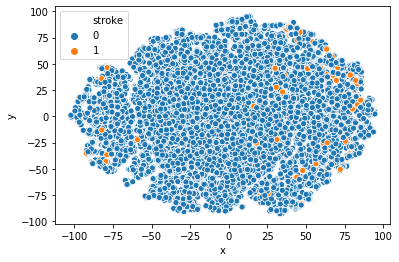

In [46]:
m = TSNE(perplexity=10)
tsne_features = m.fit_transform(df)
df['x'] = tsne_features[:,0]
df['y'] = tsne_features[:,1]
sns.scatterplot(x='x', y='y', hue='stroke', data=df)

In [47]:
perplexities = [5, 10, 25, 50]
lrs = [10, 100, 1000]

In [ ]:
for i in perplexities:
    for lr in lrs:
        fig = plt.figure()
        m = TSNE(perplexity=i)
        tsne_features = m.fit_transform(df)
        df['x'] = tsne_features[:,0]
        df['y'] = tsne_features[:,1]
        sns.scatterplot(x='x', y='y', hue='stroke', data=df)
        fig.suptitle('LR: {}, Perplexity: {}'.format(lr, i), fontsize=20)
        # Show/save figure as desired.
        plt.show()

In [ ]:
df['x'] = tsne_features[:,0]
df['y'] = tsne_features[:,1]

In [ ]:
sns.scatterplot(x='x', y='y', hue='stroke', data=df)

In [ ]:
fig, axs = plt.subplots(2, 2)
axs[0, 0].plot(my_tsne(1))
axs[0, 1].plot(my_tsne(20))
axs[1, 0].plot(my_tsne(50))
axs[1, 1].plot(my_tsne(100))

#axs[1, 1].set_title('Axis [1,1]')